<a href="https://colab.research.google.com/github/NYU-IEP-2022-2023-Assignments/Checkpoint-3/blob/main/Checkpoint-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import scipy.optimize
import itertools,operator
from scipy.integrate import solve_ivp


# Lab 5 analysis results

At the end of the checkpoint, you'll compare your simulated results to your measured results

The first part of the code here will load and analyze your lab 5 results using a subset of the lab 5 analysis solution. It runs fine on the sample data; if it doesn't work with your data, please check the directory names and keys.

**Edit the values in the block below to match your lab 5 data**

In [2]:
# MODIFY THIS LINE SO THAT THE URL POINTS TO YOUR DATA REPOSITORY by replacing "your_github_username" with your github user name 
# DO NOT delete the "data" at the end of the line 
!git clone https://github.com/NYU-IEP-2022-3-Classroom/Lab5-Sample-Data data
largeBobDirectory = 'data/Large Bob'
smallBobDirectory = 'data/Small Bob'


lg_dir = ("1", "2", "3", "4", "5", "6", "7", "8","9","10") #if needed, replace with your directory names
lg_h = np.array((1,2,3,4,5,6,7,8,9,10),'float') #if you changed directory names, make sure you have matching distances here

sm_dir = ("1", "2", "3", "4", "5", "6", "7", "8","9","10") #if needed, replace with your directory names
sm_h = np.array((1,2,3,4,5,6,7,8,9,10),'float') #if you changed directory names, make sure you have matching distances here



Cloning into 'data'...
remote: Enumerating objects: 402, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 402 (delta 0), reused 9 (delta 0), pack-reused 393
Receiving objects: 100% (402/402), 58.29 MiB | 15.06 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Updating files: 100% (510/510), done.


#Possibly useful fitting functions

In [3]:
# fitting an exponential
# exponential has two parameters, the y-intercept (a) and the
# exponential multiplier constant (b which for our purposes is -1/tau)
# inputs: x,y - numpy arrays
# outputs: a: fit value of y(0)
#          b: fit value of exonent
#          fity: a * e^(bx) 
#
# fit exponential fast is like fit exponential but fits a line to the logarithm instead of doing the nonlinear fit
def fitExponential(x,y):
  #rescale/recenter data so x starts at 0; y has max value of 1
  xx = x - np.min(x)
  yy = y / np.max(y)
  fitparams, *_ = scipy.optimize.curve_fit(lambda xdata, a, b : a*np.exp(b * xdata), xx, yy, (1, -1/max(xx)))
  a,b = fitparams
  a = a*np.max(y)*np.exp(-b*np.min(x)) #undo effects of rescaling, recentering
  return (a,b, a*np.exp(b*x))

def fitExponentialFast(x,y):
  xx = x - np.min(x)
  yy = y / np.max(y)
  p = np.polyfit(xx, np.log(yy),1)
  a = np.exp(p[1])
  b = p[0]
  a = a*np.max(y)*np.exp(-b*np.min(x)) #undo effects of rescaling, recentering
  return (a,b, a*np.exp(b*x))


# fitting a line
# line is polynomial of degree 1
# two free parameters, the slope and the y intercept
# inputs: x,y - numpy arrays
# outputs: slope (m): fit value of slope
#          intercept (b): fit value of intercept (y(0))
#          fity: m*x + b
def fitLine(x,y):
  p = np.polyfit(x,y,1)
  slope = p[0]
  intercept = p[1]
  return (slope, intercept, slope*x + intercept)



##After running this block, you should see the lifetime vs. height for your small and large bobs 

This runs a subset of the lab5 analysis to generate the lifetime vs separation data. 

large bob results will be stored in `lg_h` (separation in mm), `lg_tau` (lifetime in seconds), and `lg_tau_sem` (standard error of the mean lifetime)

small bob results will be stored in `sm_h` (separation in mm), `sm_tau` (lifetime in seconds), and `sm_tau_sem` (standard error of the mean lifetime)


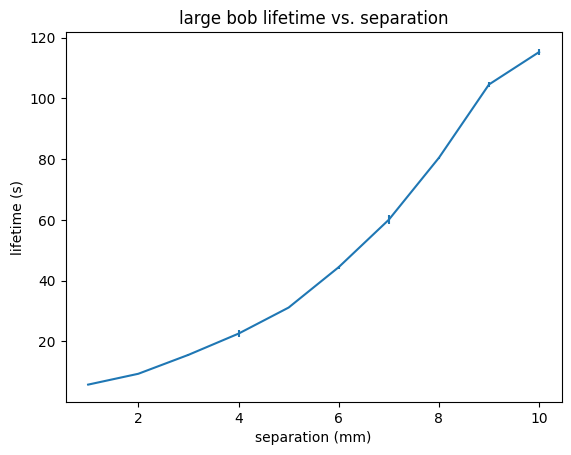

large bob results stored in: lg_h, lg_tau, lg_tau_sem


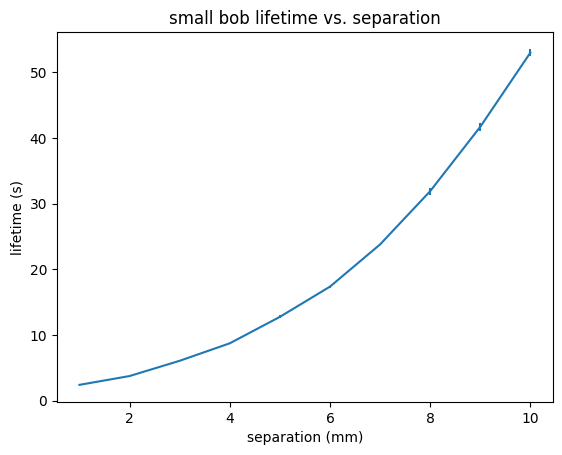

small bob results stored in: sm_h, sm_tau, sm_tau_sem


In [4]:
def findOrbitFiles (startdir):
  #orbitFiles = findOrbitFiles(startdir)
  # input stardir: path to top level directory (e.g. data_repository/large bob)
  # output orbitFiles: dictionary with paths to orbit files, key names are taken from directories under startdir 
  #   e.g. if startdir has a directory 2mm, then
  #   orbitFiles["2mm"] is a list of paths to all slope files (end _slope.txt) 
  #   under this directory, even in subdirectories

  #https://stackoverflow.com/questions/3964681/find-all-files-in-a-directory-with-extension-txt-in-python
  #https://www.kite.com/python/answers/how-to-search-for-specific-files-in-subdirectories-in-python

  orbitFiles = dict()
  for entry in os.scandir(startdir):
    if (entry.is_dir):
      key = entry.name
      orbitFiles[key] = sorted(glob.glob(entry.path + '/**/*_orbit.txt'))
  return orbitFiles

# needed to check data validity
# returns the indices of the first and last element of the largest sequence of true in a list of booleans
def longestTrueSequence(seq):
  #adapted from https://stackoverflow.com/questions/40166522/find-longest-sequence-of-0s-in-the-integer-list
  r = max((list(y) for (x,y) in itertools.groupby((enumerate(seq)),operator.itemgetter(1)) if x), key=len)
  return (r[0][0], r[-1][0])

# Checking data validity (no wild outliers)
# returns indices of the longest sequence of valid data
def sanityCheck(time, slope, amplitude, number, maxTime = np.inf):
  dt = np.diff(time)
  dslope = np.diff(np.abs(np.log(slope)))
  damplitude = np.diff(np.abs(np.log(amplitude)))
  dn = np.diff(number)
  maxperiod = 5 #equivalent to 6 meter pendulum
  maxchange = np.log(1.25) #don't allow an INCREASE of more than 25%
  valid = ((dt > 0) & (dt < maxperiod) & (dslope < maxchange) & (damplitude < maxchange) & (dn > 0) & (dn == 2))
  (start,stop) = longestTrueSequence(valid)
  if start > 0:
    start = start+1
  t0 = time[start]
  tt = time[start:stop+1]
  stop = np.argmax(tt[(tt-t0) <= maxTime]) + start
  return range(start, stop+1)

# load slope and get longest valid sequence
# takes the absolute value of slope 
# inputs: filepath - path of the file
#         maxTime - optional, longest duration to load
# outputs: time - time of the crossing: (file contains every other crossing, e.g. 1 per period)
#          slope - absolute value of slope at the crossing (V/s)
#          majaxis - major axis (mm)
#          minaxis - minor axis (mm)
#          
def loadOrbitFile(filepath, maxTime = 10000000):
  #num crossings	time (s)	maj axis (mm)	min axis (mm)	theta (rad )	slope (V/s)
  num, time, majaxis, minaxis, theta, slope = np.loadtxt(filepath, skiprows = 1, unpack=True)
  validInds = sanityCheck(time,np.abs(slope),majaxis,num,maxTime)
  num = num[validInds]
  time = time[validInds]
  time = time - time[0] #0 reference time
  majaxis = majaxis[validInds]
  minaxis = minaxis[validInds]
  slope = np.abs(slope[validInds])

  return (time,slope,majaxis,minaxis)


def analyzeFile(file, slope_plot_axis = None, ampsq_plot_axis = None):
  
  time,slope,majaxis,minaxis = loadOrbitFile(file)

  #store the total energy in the variable ampsq
  ampsq = majaxis**2 + minaxis**2

  a_slope,b_slope,slope_fit = fitExponential(time, slope) 

  #CODE1: fit an exponential to the amplitude squared data
  a_ampsq, b_ampsq, ampsq_fit = fitExponential(time,ampsq) #your code here

  if not(slope_plot_axis is None):
    slope_plot_axis.semilogy(time,slope)
    #CODE2: use semilogy to plot the fit slope vs time, as a dashed black line
    slope_plot_axis.semilogy(time,slope_fit, 'k--')

  if not(ampsq_plot_axis is None):
    #CODE3: use semilogy to make a plot of time on the linear x-axis vs. amplitude squared on the logarithmic y-axis 
    ampsq_plot_axis.semilogy(time, ampsq)#(#your code here#) 
    ampsq_plot_axis.semilogy(time, ampsq_fit, 'k--')
    #CODE4: use semilogy to plot the fit slope vs time, as a dashed black line
 
  
  lifetime_slope = -1/b_slope
  #CODE5: calculate the amplitude squared lifetime and store the result in lifetime_ampsq
  lifetime_ampsq = -1/b_ampsq

  return (lifetime_slope, lifetime_ampsq)

def analyzeDirectory(listOfFiles, slope_plot_axis = None, ampsq_plot_axis = None): 
  #create empty lists to store lifetimes
  slope_lifetime = []
  ampsq_lifetime = []
  for file in listOfFiles:
    (slope_tau, ampsq_tau) = analyzeFile(file, slope_plot_axis, ampsq_plot_axis)
    slope_lifetime.append(slope_tau)
    ampsq_lifetime.append(ampsq_tau)
  return(np.array(slope_lifetime), np.array(ampsq_lifetime))

try:
  # loading data, need to know file structure of repository
  largeBobFiles = findOrbitFiles(largeBobDirectory)
except:
  print('could not load large bob files from ' + largeBobDirectory)

try:
  # loading data, need to know file structure of repository
  smallBobFiles = findOrbitFiles(smallBobDirectory)
except:
  print('could not load large bob files from ' + smallBobDirectory)

try:
  dirs_to_analyze = [largeBobFiles[k] for k in lg_dir]

  #initialize numpy arrays
  lg_tau = lg_h*0.;
  lg_tau_sigma = lg_h*0.;
  lg_tau_sem = lg_h*0.;

  for i in range(len(dirs_to_analyze)):
      (_,lifetime) = analyzeDirectory(dirs_to_analyze[i])
      lg_tau[i] =  np.mean(lifetime)#CODE 15: calculate mean of lifetime list
      lg_tau_sigma[i] = np.std(lifetime,ddof=1)
      lg_tau_sem[i] = lg_tau_sigma[i] / np.sqrt(len(lifetime))

  plt.errorbar(lg_h, lg_tau, lg_tau_sem)   
  plt.xlabel('separation (mm)')
  plt.ylabel('lifetime (s)')
  plt.title('large bob lifetime vs. separation')
  plt.show()
  print ('large bob results stored in: lg_h, lg_tau, lg_tau_sem')
except:
  print('large bob not analyzed')


try:
  sm_dirs_to_analyze = [smallBobFiles[k] for k in sm_dir]

  #initialize numpy arrays
  sm_tau = sm_h*0.;
  sm_tau_sigma = sm_h*0.;
  sm_tau_sem = sm_h*0.;

  for i in range(len(sm_dirs_to_analyze)):
      (_,lifetime) = analyzeDirectory(sm_dirs_to_analyze[i])
      sm_tau[i] =  np.mean(lifetime)#CODE 15: calculate mean of lifetime list
      sm_tau_sigma[i] = np.std(lifetime,ddof=1)
      sm_tau_sem[i] = sm_tau_sigma[i] / np.sqrt(len(lifetime))
  plt.errorbar(sm_h, sm_tau, sm_tau_sem)   
  plt.xlabel('separation (mm)')
  plt.ylabel('lifetime (s)')
  plt.title('small bob lifetime vs. separation')
  plt.show()
  print ('small bob results stored in: sm_h, sm_tau, sm_tau_sem')   
except:
   print('small bob not analyzed')




#Checkpoint 2 redux

As a reminder / to get us all on the same page, here are solutions from Checkpoint 2 you can use moving forward

Checkpoint 2 asked you to write a series of commands to accomplish:

calculate the lifetime vs separation betwen 1 and 10 mm as follows

1. initialize empty list `lifetime = []`

1. define height = np.arange(1,11)

2. `for h in height:`
  1. calculate z0 ($h/1000 + .003$)
  1. calculate Q0 as `QLabGuess(z0)` - the lifetime for small oscillations that don't change the height much
  1. define `s_span` as `(0, 3*Q0)`
  1. define `s_eval` as 0, 0.1, 0.2 ... , 3*Q0
  1. use `solve_ivp` to integrate the variable damped oscillator (`variableDampedOscillatorDerivative`) with initial position 0.1, initial velocity 0, and extra arguments z0, L = 1 m, and QLabTest. Store the result in sol
  1. Calculate `U =0.5*(sol.y[0]**2 + sol.y[1]**2)`
  1. find the best fit exponential relation between `U` and `sol.t` $U = a e^{ b t}$
  1. append `-1/b` to `lifetime`

1. Convert lifetime to a numpy array and divide by $\omega = \pi s^{-1}$ to get a lifetime in seconds

1. Plot lifetime vs. h

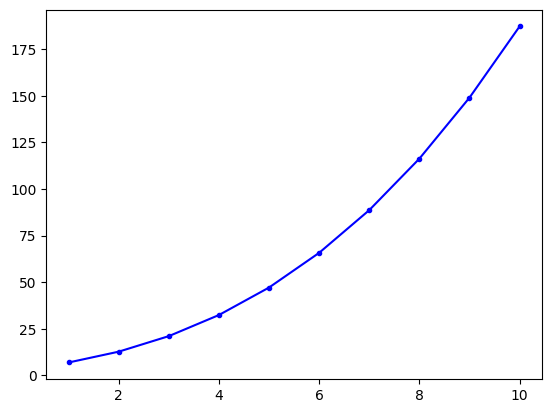

In [5]:
def dampedOscillatorDerivative (s,y,Q):
  return (y[1],-y[0]-y[1]/Q) #last week's solution

def ZofX (z0, L, x):
  return z0 + 0.5*x**2/L

def variableDampedOscillatorDerivative (s, y, z0, L, QofZ):
  z = ZofX(z0,L,y[0])
  Q = QofZ(z)
  return  (y[1],-y[0]-y[1]/Q)

def QPowerLaw (z, Qref = 17, zref = 0.004, n = 3):
  return Qref * (z/zref)**n

def QLabGuess (z):
  return QPowerLaw(z, 30, .005, 3)

Qconst = lambda z : 30


lifetime = []
height = np.arange(1,11)
for h in height:
  z0 = h/1000 + 0.003
  Q0 = QLabGuess(z0)
  s_span = (0,3*Q0)
  s_eval = np.arange(0,3*Q0,0.1)
  sol = solve_ivp(variableDampedOscillatorDerivative,s_span, (0.1,0), t_eval = s_eval, args = (z0,1,QLabGuess) )
  U = 0.5*(sol.y[0]**2 + sol.y[1]**2)
  a,b,_ = fitExponential(sol.t, U)
  lifetime.append(-1/b)
lifetime = np.array(lifetime)/np.pi

plt.plot(height, lifetime, 'b.-')

#Enapsulate the checkpoint 2 simulation into a function

We want to write a function to simulate a damping experiment at multiple heights 



Here I would like you to write a function `lifetimeVsHeight(height, QofZ, magnetCenter, L = 1)` that accomplished the following (changes **bolded**)

1. initialize empty list `lifetime = []`

2. `for h in height:`
  1. calculate z0 **(`h + magnetCenter`)** (from now on, we will work only with lengths in meters)
  1. calculate Q0 as **`QofZ(z0)`**
  1. define `s_span` as **`(-np.pi/2, 2.5*Q0)`**
  1. define `s_eval` as **0, $\pi$, $2\pi$, ..., 2.3Q0** (this matches your experimental conditions, where you measured the energy every crossing and ended after 2.3 lifetimes) 
  1. use `solve_ivp` to integrate the variable damped oscillator (`variableDampedOscillatorDerivative`) with initial position 0.1, initial velocity 0, and extra arguments **z0, L, and QofZ**. Store the result in sol
  1. Calculate `U =0.5*(sol.y[0]**2 + sol.y[1]**2)`
  1. find the best fit exponential relation between `U` and `sol.t` $U = a e^{ b t}$
  1. append `-1/b` to `lifetime`

1. Convert lifetime to a numpy array and **divide by $\omega = \sqrt{g/L}$** to get a lifetime in seconds (g = 9.802)

1. **return lifetime**

In [ ]:
def lifetimeVsHeight(height, QofZ, magnetCenter, L = 1):
 ## your code here
 return lifetime

#these plots should be nearly identical but not exactly the same due to differences in how omega is defined
plt.plot(height, lifetime, height, lifetimeVsHeight(height/1000, QLabGuess, .003, 1))

According to [Thess et al. 2007](https://doi.org/10.1088/1367-2630/9/8/299), the drag on a vertically oriented permanent magnet passing over a conducting sheet is given by

$\vec{F}_{drag} = A \frac{1 - (1/(1 + d/z))^3}{z^3} \vec{v} = A \frac{(1 + d/z)^3 - 1}{(z + d)^3} \vec{v}$

where $d$ is the thickness of the aluminum plate and $z$ is the distance from the center of the magnet to top surface of the plate

The constant $A = \frac{\mu_0^2 m^2 \sigma}{128 \pi}$,  where $\mu_0$ is the magnetic permeability of free space, $m$ is the strength of the magnetic dipolse, and $\sigma$ is the conductivity of the material.

For permanent magnets, the dipole moment $m$ is calculated as $m = \frac{1}{\mu_0}B_r V$, where $V$ is the volume of the magnet and $B_r$ is the residual flux density, which is a propery of the magnet you can look up. So $A = \frac{(B_r V)^2 \sigma}{128 \pi}$

The magnet you used in lab is a 3/16" thick, 3/8" diameter N52 neodymium magnet with residual magnetization [1.4 T](https://www.arnoldmagnetics.com/wp-content/uploads/2017/11/N52-151021.pdf). (keep in mind that 1" = .0254 meters)

The aluminum disk was made from 5052 Aluminum ([$\sigma = 2.065*10^7/(\Omega m)$](https://www.nde-ed.org/NDETechniques/EddyCurrent/ET_Tables/ET_matlprop_Aluminum.xhtml) ) and was 1/8" thick. 

The mass of your (**large**) bob is $\approx$ 0.55 kg and the length of your pendulum is about 1 m (feel free to substitute the correct values from your lab notebook).


Recalling that if $\vec{F}_{drag} = - \beta(z) \vec{v}$, we define $Q(z) \equiv \frac{m \omega}{\beta(z)}$, please write a function 

`QDipole(z, mass = 0.55)` that uses the above formulae and constants to find instantaneous Q as a function of z

Test your function by plotting the `QDipole(lg_h)` vs. `lg_h` and $\omega$*`lg_tau` vs. `lg_h` on the same axes. They won't be exactly equal, but they should be at least of the same order of magnitude. 

**If your small bob data looks better to you,** change the mass in QDipole to match the mass you measured and for the rest of this workbook, everywhere you see `lg` (e.g. `lg_h`, `lg_tau`), change it to `sm`


In [ ]:
def QDipole(z, mass = 0.55):
  inch = .0254
  sigma = 2.065E+07 #1/(ohm m) 5052 aluminum - https://www.nde-ed.org/NDETechniques/EddyCurrent/ET_Tables/ET_matlprop_Aluminum.xhtml
  Br = 1.4 #Tesla N52 - https://www.arnoldmagnetics.com/wp-content/uploads/2017/11/N52-151021.pdf
  magnet_dia = .375*inch
  magnet_thick = 3/16.0 * inch
  length = 1
  g = 9.802
  d = .125*inch

  V = #area times thickness 
  A = #your code here

  omega = #your code here

  beta = #your code here

  return mass*omega/beta

#your test plot here

Consider the force law $\vec{F}_{drag} = A \frac{1 - (1/(1 + d/z))^3}{z^3} \vec{v} = A \frac{(1 + d/z)^3 - 1}{(z + d)^3} \vec{v}$

For $d \gg z$, $1 - (1/(1 + d/z))^3 \approx 1$ and $\vec{F} \propto z^{-3}$ 
$d \ll z$, $1 - (1/(1 + d/z))^3 \approx 3d/z$, so $\vec{F} \propto h^{-4}$.

For small $z$ then $Q \propto z^3$ and for large $z$, $Q \propto z^4$. 

Please make a plot showing Q along with these limits

1. Define a $z$ axis `zx` with 100 elements ranging from .0034 m to .00144 m (3.4 to 14.4 mm). `zx` should be in terms of meters. If the distance to the magnet center is about 2.4 mm, then this is a range of separations from 1 to 12 mm. 
1. Calculate `Q = QDipole(zx)` (remember that QDipole wants z in meters, not mm)
1. When $z$ is small (i.e. when $z \ll d \sim .003$m), $Q \propto z^{3}$. Please calculate `Q3 = C3 * zx**3` where `C3` is chosen so that `C3*(1e-4)**3 == QDipole(1e-4)`
1. When $z$ is large (i.e. when $z \gg d \sim .003$m), $Q \propto z^{4}$. Please calculate `Q4 = C4 * zx**4` where `C4` is chosen so that `C4*(1)**3 == QDipole(1)`

1. Plot `Q`, `Q3`, and `Q4` vs. `zx` with  lines of different colors on the same axes. 

1. On a new set of axes, make the same plots, but set a logarithmic scale

In [ ]:
#your code here

#Simulate the lifetime vs. height for the Dipole force law

Choosing either large or small bob data, use the function `lifetimeVsHeight` to calculate the simualted lifetime  (store in `tau_sim`) at
- `lg_h/1000` (or `sm_h/1000`)
- for the force law `QDipole` (if you need to change the mass from the default value, use the force law `lambda z : QDipole(z,newmass)`
- with a magnetCenter 2.4 mm (3/32") from the bottom of the magnet
- with a pendulum length of 1 meter (or the value from your labbook)

Plot the simulated lifetime vs. height as well as the experimental results, with labels and a legend

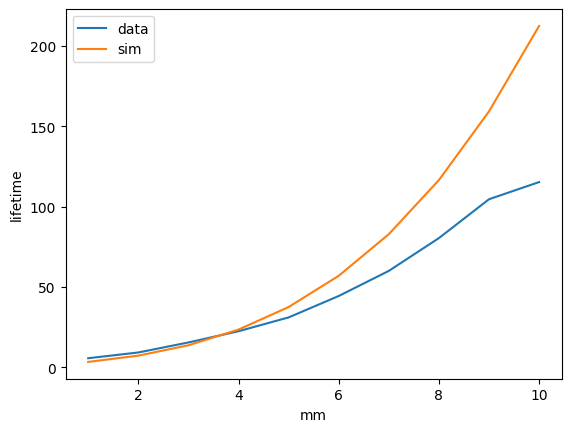

In [9]:
#your code here
plt.xlabel('mm')
plt.ylabel('lifetime')
plt.legend();

#Add in the effect of the steel bob

When the magnet is attracted to the steel bob (relative permeability about 1000), there is an image dipole. If the bob were flat, this dipole would have the same magnitude and be located so that it appeared to be another magnet touching the bob (this is only true because the magnet is oriented perpendicular to the surface of the bob). In other words
1. Call the bottom surface of the bob $z = 0$
1. The real magnet appears as a dipole with magnitude $M$ located below the bob at $z = -t_m/2$, where $t_m = 3/16" = 4.8$mm is the thickness of the magnet. 
1. The image magnet appears as a dipole of the same magnitude $M$ located inside the bob at $z = +t_m/2$.
1. Combined, the two dipoles have a magnitude $2M$ and are located at $z = 0$. 

Let's simulate what would happen when this combined magnet interacts with the aluminum plate. You could redo the calculations for QDipole, but if you look carefully, you'll see that QDipole $\propto$ 1/$M^2$, so you can just adjust it using a lambda expression. You will also need to adjust the center location - instead of being .0024 meters above the bottom of the magnet, it's .0048 meters above the bottom of the magnet (at the surface of the bob). 

Choosing either large or small bob data (change the mass in your definition `QDipole` appropriately), use the function `lifetimeVsHeight` to calculate the lifetime (store in `tau_flat`) at
- `lg_h/1000`  (or `sm_h/1000`)
- for the force law `lambda z : QDipole(z)/4` (if you need to change the mass from the default value, use the force law `lambda z : QDipole(z,newmass)/4`)
- with a magnetCenter 4.8 mm (3/16") from the bottom of the magnet
- with a pendulum length of 1 meter (or the value from your labbook)

Plot the first simulated lifetime (`tau_sim`) vs. height, this simulation (`tau_flat`), and the experimental results,  with labels and a legend



In [ ]:
#your code here (hint: you can copy a lot from the previous cell)

#Add in the effect of the SPHERICAL steel bob

Because the bob is round, image charges appear to be both smaller and closer to the surface of the bob than they would otherwise. As a result, if the real magnet is a dipole of magnitude $M$, located a distance $z$ below the bob, the image dipole appears to be of magnitude $\alpha^2M$ and located a distance $\alpha z$ above the surface of the ball, where $\alpha = 1 - z/R$

The resulting combination is a dipole of magnitude $(1 + \alpha^2)M$ located at a coordinate $\frac{-z + \alpha^3 z}{1 + \alpha^2}$ relative to the bottom of the bob, or $z\frac{\alpha^3 + 2\alpha^2 + 1}{1 + \alpha^2}$ above the bottom of the magnet. 

Here $z$ is the half thickness of the magnet = $3/32$" = .0024 m.  For the large bob, $R$ = 1" ($\alpha = 29/32$); for the small bob, $R = .75$" ($\alpha = 7/8$). Use these to find `tau_ball` as before: `lifetimeVsHeight` at
- `lg_h/1000`  (or `sm_h/1000`)
- for the force law `lambda z : QDipole(z)/(1 + alpha**2)**2` (if you need to change the mass from the default value, use the force law `lambda z : QDipole(z,newmass)/(1 + alpha**2)**2`)
- with a magnetCenter at $.0024 \frac{\alpha^3 + 2\alpha^2 + 1}{1 + \alpha^2}$
- with a pendulum length of 1 meter (or the value from your labbook)  

In [ ]:
#your code here

#Apply a fudge factor

You may already be pretty close to predicting the experimental values with *no free parameters*. That is, you've written down an expression for the force law that involves only predetermined quantities (conductivity of aluminum, mass of the ball, thickness of the plate, size of the magnet, residual magnet strength, size of the bob, anything else?) and predicted its consequences. 

But maybe there's a little bit of imperfection somewhere - maybe the magnet isn't quite as strong as it should be, or wasn't lined up perfectly vertically, or the aluminum conductivity doesn't match the book value exactly. All of these cases would cause $Q$ to change by a constant factor. 

So let's see if we can find a correction to Q that makes the simulation line up with the data

1. Define a function `lifetimeWithFudge(f):` that calculates `lifetimeVsHeight` 
- at `lg_h/1000` (or `sm_h/1000`)
- for the force law `lambda z : f*QDipole(z)/(1 + alpha**2)**2` (if you need to change the mass from the default value, use the force law `lambda z : QDipole(z,newmass)/(1 + alpha**2)**2`) **this is a change to the force law from last time**
- with a magnetCenter at $.0024 \frac{\alpha^3 + 2\alpha^2 + 1}{1 + \alpha^2}$ 
- with a pendulum length of 1 meter (or the value from your labbook)  
- and returns the lifetimes as a numpy array (1 lifetime per value in `lg_h` or `sm_h`)
2. Define a function `fudgeError(f)` (or use a lambda expression) that returns the sum (`np.sum`) of `(lifetimeWithFudge(f) - lg_tau)**2` (or `sm_tau`)  
3. `res = scipy.optimize.minimize_scalar(fudgeError, bounds=(.5,1.5))` will find the best fudge factor with the range 50% to 150% to match the measured values. 
4. `ff = res.x` stores the fudge factor in ff

Please plot the data, ball simulation lifetime, and the new best fit lifetime (`lifetimeWithFudge(ff)`) on the same axes, with labels and legend. In the legend, provide the fudge factor

In [ ]:
def lifetimeWithFudge(f):
  return #your code here
fudgeError = #your lambda expression here (or rewrite as a function with a return value)

res = scipy.optimize.minimize_scalar(fudgeError, bounds=(.5,1.5))
ff = res.x

#your code here 


#Does anything work (optional)?

You might be wondering if the match between data and corrected model means anything - maybe you could have fit anything the same way and gotten the same result. 

You can test this by trying to fit other models to the data this way. For example:

Do the same excercise, but use a new `lifetimeWithFudgeDipole` that uses the force law `f*QDipole(z)` (no corrections for the ball) at an offset of .0024 mm. 

Plot this as above - can you still match the data? (you can also consider whether the fudge factor you need is farther from 1 than in the work you did above)


In [ ]:
#your code here